In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **XLNet**

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/DIY/Tools_DIY_outdoor.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()


,Rating,Review,Product Name,Product Category,Emotion,Data Source,Sentiment
0,5.0,ami 2 ta niaci khub e valo shobaie bosta parca...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Sadness,Daraz,Negative
1,5.0,Dolna ta khubi sundor amar abong amar khub i p...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Love,Daraz,Positive
2,5.0,এতটা ভালো আশা করি নাই সত্যিই খুব ভালো হয়েছে ।...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Happy,Daraz,Positive
3,5.0,Dolna Ta khubi sundor .tnx seller k emon sundo...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Happy,Daraz,Positive
4,5.0,দোলনা টা খুব ই সুন্দর আমার খুব পসন্দ হইসে❤️❤️❤...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Happy,Daraz,Positive


In [ ]:
!pip install SentencePiece
# then restart the session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
from transformers import DataCollatorWithPadding
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/DIY/Tools_DIY_outdoor.csv')

# Encode the labels
label_encoder = LabelEncoder()
data['encoded_emotion'] = label_encoder.fit_transform(data['Sentiment'])

# Ensure the text column is a list of strings
data['Review'] = data['Review'].astype(str)

# Split the dataset
train_data, test_data = train_test_split(
    data, train_size=5320, random_state=42, stratify=data['encoded_emotion']
)

# Sample exactly 1330 instances for the test set
test_data = test_data.sample(n=1330, random_state=42)

# Separate text and labels for train, test, and validation sets
train_text, train_labels = train_data['Review'].tolist(), train_data['encoded_emotion'].tolist()
test_text, test_labels = test_data['Review'].tolist(), test_data['encoded_emotion'].tolist()
val_text, val_labels = test_data['Review'].tolist(), test_data['encoded_emotion'].tolist()


# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_function(text_list):
    return tokenizer(text_list, padding='max_length', truncation=True, max_length=128, return_tensors='tf')

# Tokenize data
train_encodings = tokenize_function(train_text)
test_encodings = tokenize_function(test_text)


val_encodings = tokenize_function(val_text)

# Convert labels to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))


# Model
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset.shuffle(3000).batch(16), epochs=20, batch_size=16, validation_data=val_dataset.batch(16))

# Evaluate the model
eval_results = model.evaluate(test_dataset.batch(16))
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/20
333/333 [==============================] - 194s 453ms/step - loss: 0.4210 - accuracy: 0.8184 - val_loss: 0.3848 - val_accuracy: 0.8398
Epoch 2/20
333/333 [==============================] - 153s 459ms/step - loss: 0.3648 - accuracy: 0.8385 - val_loss: 0.3328 - val_accuracy: 0.8541
Epoch 3/20
333/333 [==============================] - 154s 463ms/step - loss: 0.3092 - accuracy: 0.8628 - val_loss: 0.3513 - val_accuracy: 0.8436
Epoch 4/20
333/333 [==============================] - 154s 462ms/step - loss: 0.2739 - accuracy: 0.8795 - val_loss: 0.2876 - val_accuracy: 0.8744
Epoch 5/20
333/333 [==============================] - 154s 463ms/step - loss: 0.2273 - accuracy: 0.8996 - val_loss: 0.3229 - val_accuracy: 0.8752
Epoch 6/20
333/333 [==============================] - 154s 464ms/step - loss: 0.1937 - accuracy: 0.9164 - val_loss: 0.3879 - val_accuracy: 0.8729
Epoch 7/20
333/333 [==============================] - 154s 462ms/step - loss: 0.1894 - accuracy: 0.9231 - val_loss: 0.4368 -

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

In [ ]:
# Predictions for confusion matrix
y_pred = model.predict(test_dataset.batch(16)).logits
y_pred = tf.argmax(y_pred, axis=1).numpy()

# Get the unique classes in test_labels
unique_classes = np.unique(test_labels)

# Generate target names based on unique classes
target_names = [label_encoder.inverse_transform([cls])[0] for cls in unique_classes]

print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
precision = precision_score(test_labels, y_pred, average='macro')
recall = recall_score(test_labels, y_pred, average='macro')
f1 = f1_score(test_labels, y_pred, average='macro')
print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")


84/84 [==============================] - 15s 141ms/step
Confusion Matrix:
 [[ 154   92]
 [  58 1026]]
Precision: 0.8220626455597935
Recall: 0.7862553625536255
F1 Score: 0.8021845959806289
Accuracy: 0.8872180451127819


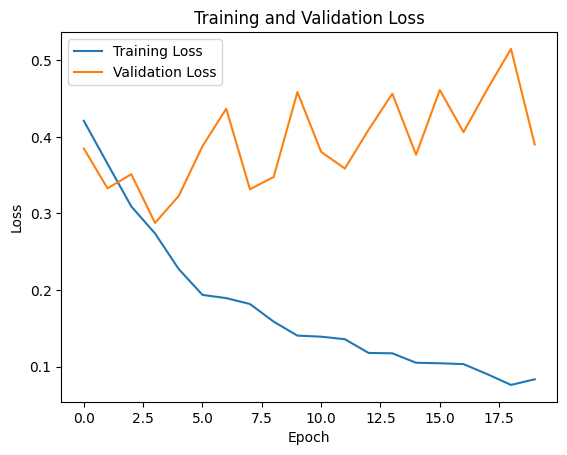

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Assuming 'model' is your trained TFRobertaForSequenceClassification model
# and 'model_path' is the path where you want to save the model

# Save model
model_path = '/content/drive/MyDrive/DIY/XLNet and ELMO'
model.save_weights(model_path)

print(f'Model saved at {model_path}')


Model saved at /content/drive/MyDrive/DIY/XLNet and ELMO
